In [1]:
from google.colab import drive
drive.mount('/drive')
%cd /drive/My Drive/notebooks

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
/drive/My Drive/notebooks


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np
import random
import math

In [3]:
DATA_PATH = './data'
log_PATH = "./logs/"
modelName = "MNIST_SGAN"
batch_size =128
workers = 2
epochs = 20

category_K = 10

latent_size=100

gf_dim = 64
df_dim = 64

in_h = 64
in_w =64
c_dim = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

manualSeed = 3734
print("Random Seed: ",manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  3734


In [0]:
transform = transforms.Compose(
    [
     transforms.Resize((in_h,in_w)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,)),
     ]
)


def transform_inverse (y):
  t= None
  if y.size()[0]==1:
    t=torchvision.transforms.Normalize((-1,),(2,))
  else :
    t=torchvision.transforms.Normalize((-1,-1,-1),(2,2,2))
  return t(y)

def batch_transform_inverse(y):
  x = y.new(*y.size())
  if y.size()[1]==1:
    x[:, 0, :, :] = y[:, 0, :, :] * 2 - 1
  else:
    x[:, 0, :, :] = y[:, 0, :, :] * 2 - 1
    x[:, 1, :, :] = y[:, 1, :, :] * 2 - 1 
    x[:, 2, :, :] = y[:, 2, :, :] * 2 - 1
  return x

In [0]:

train_set = torchvision.datasets.MNIST(root=DATA_PATH,train=True,
                                      download=True,transform=transform)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,
                                          shuffle =True, num_workers=workers)

test_set = torchvision.datasets.MNIST(root=DATA_PATH,train=False,
                                     download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle = False, num_workers=workers)

train_iter = iter(train_loader)
test_iter = iter(test_loader)

torch.Size([1, 64, 64])


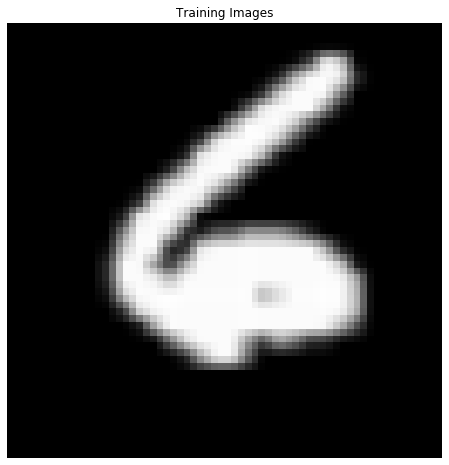

In [6]:
real_batch, label = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=2, normalize=True).cpu(),(1,2,0)))

print(real_batch[0].size())

In [7]:
label

tensor([6, 7, 3, 9, 8, 0, 3, 8, 8, 0, 8, 3, 0, 5, 8, 1, 4, 7, 4, 5, 9, 5, 6, 8,
        8, 6, 8, 6, 1, 8, 8, 1, 3, 1, 1, 3, 7, 9, 0, 2, 8, 1, 0, 5, 3, 3, 1, 2,
        0, 9, 0, 8, 6, 5, 9, 2, 5, 1, 7, 2, 9, 4, 4, 7, 9, 0, 2, 9, 2, 3, 0, 4,
        4, 8, 7, 5, 5, 8, 0, 8, 8, 2, 9, 4, 1, 4, 3, 3, 0, 0, 1, 1, 6, 4, 9, 1,
        7, 0, 4, 3, 4, 8, 7, 0, 0, 2, 6, 0, 9, 3, 2, 1, 3, 7, 5, 4, 7, 6, 5, 2,
        0, 7, 6, 8, 2, 7, 4, 7])

In [0]:
def conv_bn_lrelu_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
        nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
        nn.LeakyReLU(0.2)
    )
def tconv_bn_relu_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
      nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
      nn.ReLU()
  )
def tconv_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
  return nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding)

def conv_lrelu_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
      nn.LeakyReLU(0.2)
  )

def fc_layer(in_features,out_features):
  return nn.Linear(in_features,out_features)

In [0]:
def conv_out_size_same(size, stride):
  return int(math.ceil(float(size) / float(stride)))
s_h, s_w = in_h, in_w
s_h2, s_w2 = conv_out_size_same(s_h, 2), conv_out_size_same(s_w, 2)
s_h4, s_w4 = conv_out_size_same(s_h2, 2), conv_out_size_same(s_w2, 2)
s_h8, s_w8 = conv_out_size_same(s_h4, 2), conv_out_size_same(s_w4, 2)
s_h16, s_w16 = conv_out_size_same(s_h8, 2), conv_out_size_same(s_w8, 2)

In [0]:
import torch.nn as nn

class G(nn.Module):
  def __init__(self):
    super(G,self).__init__()
    self.fc_layer1 = fc_layer(latent_size,s_h16*s_w16*gf_dim*8)
    self.bn_layer1 = nn.BatchNorm2d(gf_dim*8)
    self.up_sample_layer2 = tconv_bn_relu_layer(gf_dim*8,gf_dim*4,4,stride=2,padding=1)
    self.up_sample_layer3 = tconv_bn_relu_layer(gf_dim*4,gf_dim*2,4,stride=2,padding=1)
    self.up_sample_layer4 = tconv_bn_relu_layer(gf_dim*2,gf_dim,4,stride=2,padding=1)
    self.up_sample_layer5 = tconv_layer(gf_dim,c_dim,4,stride=2,padding=1)
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = self.fc_layer1(x)
    x = x.view(-1,gf_dim*8,s_h16,s_w16)
    x = self.bn_layer1(x)
    x = self.up_sample_layer2(x)
    x = self.up_sample_layer3(x)
    x = self.up_sample_layer4(x)
    x = self.up_sample_layer5(x)
    x = self.tanh(x)
    return x

In [0]:
class D(nn.Module):
  def __init__(self):
    super(D,self).__init__()
    self.down_sample_layer1 = conv_lrelu_layer(c_dim,df_dim,4,stride=2,padding=1)
    self.down_sample_layer2 = conv_bn_lrelu_layer(df_dim,df_dim*2,4,stride=2,padding=1)
    self.down_sample_layer3 = conv_bn_lrelu_layer(df_dim*2,df_dim*4,4,stride=2,padding=1)
    self.down_sample_layer4 = conv_bn_lrelu_layer(df_dim*4,df_dim*8,4,stride=2,padding=1)
    self.discriminator_layer = fc_layer(df_dim*8*s_h16*s_w16,1)
    self.classifier_layer = fc_layer(df_dim*8*s_h16*s_w16,category_K+1)
    self.sigmoid =nn.Sigmoid()
    self.softmax =nn.Softmax(dim=-1)


  def forward(self, x):
    x = self.down_sample_layer1(x)
    x = self.down_sample_layer2(x)
    x = self.down_sample_layer3(x)
    x = self.down_sample_layer4(x)
    x = torch.flatten(x,1)
    validity = self.sigmoid(self.discriminator_layer(x)).squeeze()
    label = self.softmax(self.classifier_layer(x))

    return validity, label

In [0]:
import torch.optim as optim

G_net = G().to(device)
D_net = D().to(device)

adv_loss = nn.BCELoss()
cls_loss = nn.NLLLoss()
G_optimizer = optim.Adam(G_net.parameters(),lr=0.0002,betas=(0.5,0.9))
D_optimizer = optim.Adam(D_net.parameters(),lr=0.0002,betas=(0.5,0.9))

real_label = 1
fake_label = 0


fixed_noise = torch.randn(batch_size, latent_size,device=device)

In [13]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv')!=-1 or classname.find('Linear')!=-1:
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('BatchNorm')!=-1:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)

print(G_net.apply(weights_init))
print(D_net.apply(weights_init))

G(
  (fc_layer1): Linear(in_features=100, out_features=8192, bias=True)
  (bn_layer1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up_sample_layer2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (up_sample_layer3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (up_sample_layer4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (up_sample_layer5): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (tanh): Tanh()
)
D(
  (down_sample_layer1): Se

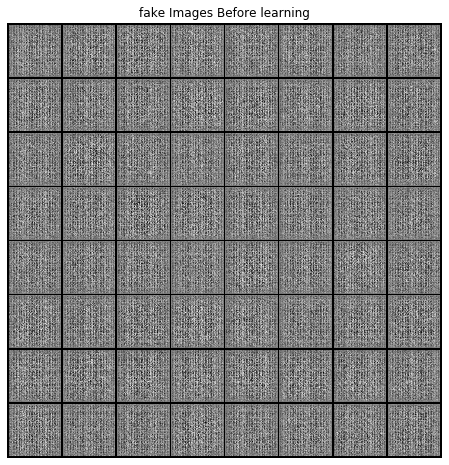

In [14]:
with torch.no_grad():
  fake_batch=G_net(fixed_noise)
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('fake Images Before learning')
plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device)[:64].view(64,c_dim,in_h,in_w),padding=2, normalize=True).cpu(),(1,2,0)))

In [15]:
fake_batch.size()

torch.Size([128, 1, 64, 64])

In [0]:
img_list = []
G_losses = []
D_losses = []

iter_per_plot = 250
plot_per_eps=(int(len(train_loader)/iter_per_plot)+1)

transform_PIL=transforms.ToPILImage()

In [18]:
for ep in range(epochs):
  for i, (data, labels) in enumerate(train_loader):
    b_size=data.shape[0]

    data = data.to(device)
    cls_label = labels.to(device) 
    cls_fake_label = torch.full((b_size,),category_K,dtype=torch.long).to(device)

    vrfy_real_label = torch.ones(b_size).to(device)
    vrfy_fake_label = torch.zeros(b_size).to(device)


    #Train D
    D_net.zero_grad()

    real_score, real_label_score = pred_real_vrfy, pred_real_cls = D_net(data)
    loss_D_real = (adv_loss(pred_real_vrfy, vrfy_real_label) + cls_loss(pred_real_cls,cls_label))/2

    z = torch.randn(b_size,latent_size).to(device)
    fake_images = G_net(z)
    fake_score, fake_label_score = pred_fake_vrfy,pred_fake_cls  = D_net(fake_images.detach())

    loss_D_fake = (adv_loss(pred_fake_vrfy,vrfy_fake_label)+cls_loss(pred_fake_cls,cls_fake_label ))/2

    loss_D = loss_D_real  + loss_D_fake
    loss_D.backward()
    D_optimizer.step()

    #Train G
    G_net.zero_grad()
    pred_fake_vrfy, _ = D_net(fake_images)
    
    loss_G = adv_loss(pred_fake_vrfy, vrfy_real_label)

    loss_G.backward()
    G_optimizer.step()

    if (i+1)%iter_per_plot == 0 or i ==0:
      real_label_score = ((real_label_score.argmax(dim=1)==cls_label)*1.0).mean()
      fake_label_score = ((fake_label_score.argmax(dim=1)==cls_fake_label)*1.0).mean()
      print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, \n P(K_gt|D,x): {:.2f}, P(real|D,x): {:.2f}, P(K_fake|D,G(z)): {:.2f}, P(real|D,G(z)): {:.2f}' 
            .format(ep, epochs, i+1, len(train_loader), loss_D.item(), loss_G.item(), 
                    real_label_score.item(),real_score.mean().item(), fake_label_score.item(),fake_score.mean().item()))
      G_losses.append(loss_G.item())
      D_losses.append(loss_D.item())
      if (i+1)%iter_per_plot*4 or i == 0 :
        with torch.no_grad():
          fake = G_net(fixed_noise).detach().cpu()
          img_list.append(vutils.make_grid(torch.reshape(fake,(b_size,c_dim,in_h,in_w))[:64], padding=2, normalize=True))
          transform_PIL(img_list[-1]).save(log_PATH+str(ep)+modelName+"_Last.png")

Epoch [0/20], Step [1/469], d_loss: 0.9457, g_loss: 3.8242, 
 P(K_gt|D,x): 0.05, P(real|D,x): 0.27, P(K_fake|D,G(z)): 0.06, P(real|D,G(z)): 0.37
Epoch [0/20], Step [250/469], d_loss: -0.4713, g_loss: 2.5210, 
 P(K_gt|D,x): 0.85, P(real|D,x): 0.74, P(K_fake|D,G(z)): 0.96, P(real|D,G(z)): 0.30
Epoch [1/20], Step [1/469], d_loss: -0.2212, g_loss: 3.0151, 
 P(K_gt|D,x): 0.91, P(real|D,x): 0.91, P(K_fake|D,G(z)): 0.86, P(real|D,G(z)): 0.61
Epoch [1/20], Step [250/469], d_loss: -0.6961, g_loss: 2.4307, 
 P(K_gt|D,x): 0.91, P(real|D,x): 0.83, P(K_fake|D,G(z)): 0.95, P(real|D,G(z)): 0.17
Epoch [2/20], Step [1/469], d_loss: -0.6372, g_loss: 4.0869, 
 P(K_gt|D,x): 0.97, P(real|D,x): 0.98, P(K_fake|D,G(z)): 0.84, P(real|D,G(z)): 0.33
Epoch [2/20], Step [250/469], d_loss: 0.7787, g_loss: 8.1197, 
 P(K_gt|D,x): 0.95, P(real|D,x): 1.00, P(K_fake|D,G(z)): 0.28, P(real|D,G(z)): 0.90
Epoch [3/20], Step [1/469], d_loss: -0.9260, g_loss: 6.2210, 
 P(K_gt|D,x): 0.95, P(real|D,x): 0.95, P(K_fake|D,G(z)): 1

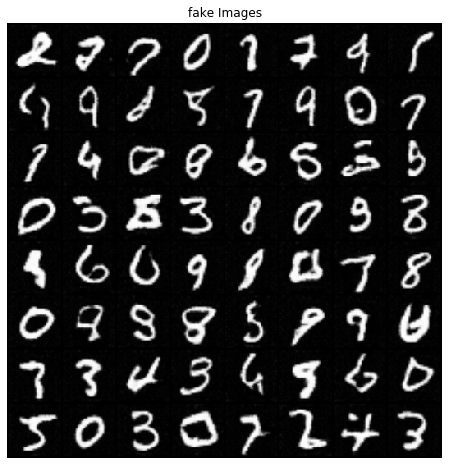

In [19]:
with torch.no_grad():
  fake_batch=G_net(fixed_noise)
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('fake Images')
plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device)[:64].view(64,c_dim,in_h,in_w),padding=2, normalize=True).cpu(),(1,2,0)))

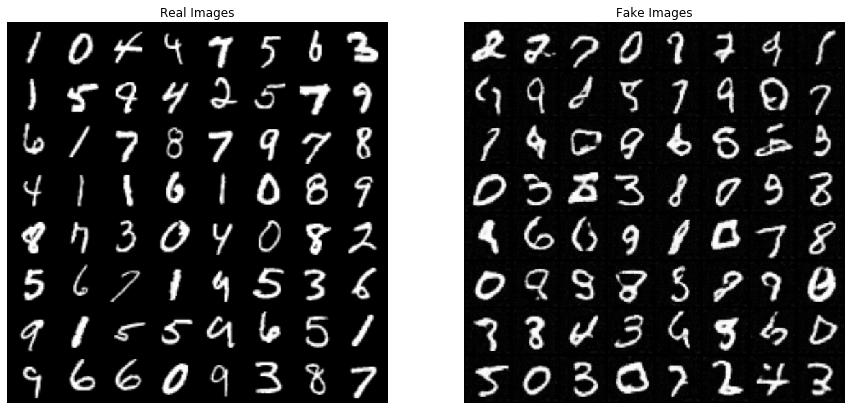

In [20]:
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

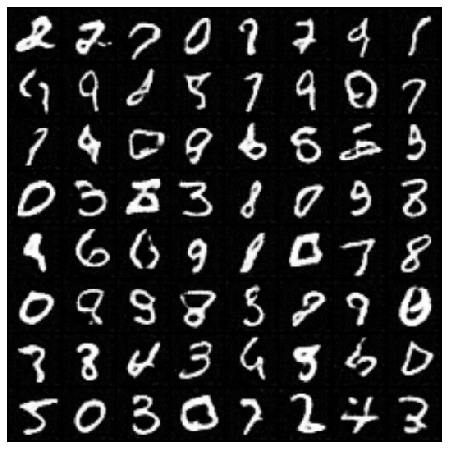

In [21]:
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
from PIL import Image
transform_PIL=transforms.ToPILImage()

p_img_list = [transform_PIL(p_image) for p_image in img_list]
p_img_list[0].save(log_PATH+modelName+'.gif', save_all=True,append_images=p_img_list[1:], optimize=False, duration=0.5, loop=0)

In [0]:
p_img_list[-1].save(log_PATH+modelName+"_last_result.png")

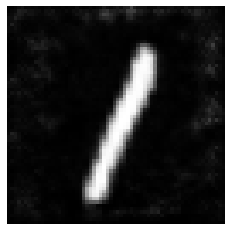

In [24]:
with torch.no_grad():
  random_noise=torch.randn(1,latent_size,device=device)
  fake=G_net(random_noise)
fake = fake.squeeze().cpu().view(c_dim,in_h,in_w)
fake_image=transform_inverse(fake)
plt.axis("off")
if fake_image.size()[0]==3:
  plt.imshow(np.transpose(fake_image,(1,2,0)))
else:
  plt.imshow(fake_image.squeeze(),cmap='gray')

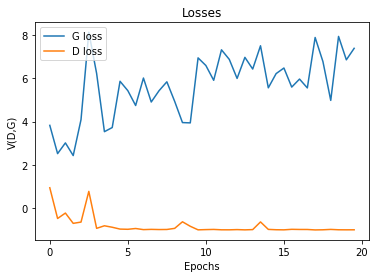

In [25]:
plt.title("Losses")
epsilon = 1/plot_per_eps
X = np.array(range(plot_per_eps*epochs))/plot_per_eps

plt.plot(X,G_losses,label="G loss")
plt.plot(X,D_losses,label="D loss")
plt.legend(loc=2)
plt.xticks(np.arange(0,epochs+1,5)) 
plt.ylabel("V(D,G)")
plt.xlabel("Epochs")
#plt.show()
plt.savefig(modelName+"_loss_figure.png")

In [0]:
torch.save(G_net.state_dict(),log_PATH+"G_"+modelName+".pth")

In [27]:
G_net.load_state_dict(torch.load(log_PATH+"G_"+modelName+".pth"))

<All keys matched successfully>

In [0]:
torch.save(D_net.state_dict(),log_PATH+"D_"+modelName+".pth")

In [29]:
D_net.load_state_dict(torch.load(log_PATH+"D_"+modelName+".pth"))

<All keys matched successfully>